# **Unifashion LLM - llava-v1.5-7b**

The notebook consists of steps taken to load mulitmodal llava model from hugging face and finetuning it with LoRA (Low-rank adaptation) adapter of unifashion LLM.

Llava Model - https://huggingface.co/liuhaotian/llava-v1.5-7b

Lora Adapter - https://huggingface.co/UniFashion/UniFashion/tree/main

We have levaraged 4 bit quantization in this notebook, due to CUDA limits. Your metrics and outcomes could differ by leveraging different configs.

**Installing dependencies**

In [1]:
!pip install accelerate bitsandbytes transformers Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.4 MB/s eta 0:00:00


**Downloading the model files from huggingface**

In [2]:
from huggingface_hub import snapshot_download
snapshot_download(repo_id="llava-hf/llava-1.5-7b-hf", local_dir="/content/llava-hf")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.93k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

'/content/llava-hf'

**Loading the model with appropriate quantization configs and processor**

In [3]:
# Import required modules
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig

# Define the quantization configuration for 4-bit loading
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

# The below code has better accuracy but couldn't load lora parameters for the LLM since CUDA Limits were reached. Prefer to use this
# quantization_config = BitsAndBytesConfig(load_in_8bit=True)

# Load the model with 8-bit quantization
model = LlavaForConditionalGeneration.from_pretrained(
    "/content/llava-hf",  # Path to the local directory where the model is stored
    local_files_only=True,
    quantization_config=quantization_config
)

# Load the processor
processor = AutoProcessor.from_pretrained(
    "/content/llava-hf",
    local_files_only=True
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

**Sample Image Test for checking base model**

In [12]:
from PIL import Image
import requests

image_url = "https://www.wildnatureimages.com/images/960/130726-063-Denali-National-Park.webp"  # Replace with your image URL
image = Image.open(requests.get(image_url, stream=True).raw)
prompt = "Describe the image."

In [13]:
# Prepare the input
full_prompt = f"USER: <image>\n{prompt} ASSISTANT:"
inputs = processor(text=full_prompt, images=image, return_tensors="pt").to("cuda")

# Generate the response
generate_ids = model.generate(**inputs, max_new_tokens=50)
response = processor.batch_decode(generate_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[1]

In [14]:
print(response)

 The image features a beautiful mountain landscape with a majestic mountain in the background. The mountain is covered in snow, and its peak is visible above the surrounding area. The scene is set against a backdrop of a clear blue sky.

In


**Dependency for adapter**

In [9]:
!pip install peft

In [10]:
!git clone https://huggingface.co/UniFashion/UniFashion

Cloning into 'UniFashion'...
remote: Enumerating objects: 139, done.
remote: Total 139 (delta 0), reused 0 (delta 0), pack-reused 139 (from 1)
Receiving objects: 100% (139/139), 14.64 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (10/10), done.
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'


Exiting because of "interrupt" signal.
^C


**Installed the MLLM_lora params that were required, terminated the above cell to not unnecessarily install other stuff in the repo.**

In [16]:
# Installed the MLLM_lora params that were required, terminated the above cell to not unnecessarily install other stuff in the repo.
from peft import PeftModel

lora_model_path = "/content/UniFashion/MLLM_lora"  # Replace with the actual path to your LoRA model directory

model = PeftModel.from_pretrained(model, lora_model_path)

/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.base_model.model.vision_tower.vision_model.encoder.layers.1.self_attn.k_proj.lora_A.default.weight', 'base_model.model.base_model.mod

# **Testing on Fashion Examples**

**Shein Tshirt Example**

In [35]:
import matplotlib.pyplot as plt

In [36]:
image_url = "https://img.ltwebstatic.com/images3_spmp/2024/11/11/c5/1731330376ae1198bc31586fb58acfa80f49917864.jpg"  # Replace with your image URL
image = Image.open(requests.get(image_url, stream=True).raw)
prompt = "Describe the fashion product in the image that is most prominently in focus, as a professional fashion expert. Dont explain other objects in image.  Provide an in-depth and detailed explanation of all visual features of the product, including its fabric, texture, color, pattern, silhouette, stitching, embellishments, and any other distinctive elements. Use precise fashion terminology and ensure the description captures the essence of the product's style and design. Avoid generalizations, and focus entirely on the key product at the center of attention."

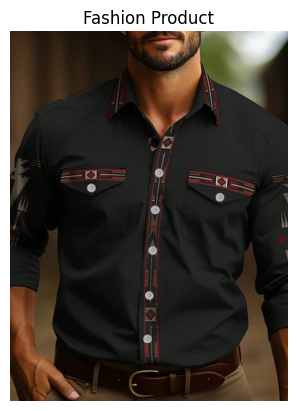

In [37]:
# Render the image
plt.imshow(image)
plt.axis("off")
plt.title("Fashion Product")
plt.show()

In [38]:
# Prepare the input
full_prompt = f"USER: <image>\n{prompt} ASSISTANT:"
inputs = processor(text=full_prompt, images=image, return_tensors="pt").to("cuda")

# Generate the response
generate_ids = model.generate(**inputs, max_new_tokens=100)
response = processor.batch_decode(generate_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[1]

**The response has detailed description along with understanding of complementary fashion products that go with it.**

In [39]:
print(response)

 The image features a man wearing a black shirt with red and white accents. The shirt has a plaid pattern, giving it a casual and stylish appearance. The fabric of the shirt appears to be of good quality, and the stitching is neat and well-executed. The shirt has a collar, which adds to its formal and polished look. The man is also wearing a brown belt, which complements the shirt and adds
